# Image content manipulation

This project demonstrates the usage of image manipulation by image segmentation and content creation in those selected areas.


In [1]:
from PIL import Image
import requests
from transformers import SamModel, SamProcessor
from diffusers import DiffusionPipeline, AutoPipelineForText2Image, AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

import torch
import numpy as np

## SAM

In order to swiftly segment objects from arbitrary images, SAM or segment anything from Meta, as shown an outstanding performance. Its qualities are being used instead a different or self established model, to keep the code parts streamlined.

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

### Extracting the mask

After SAM has been loaded, the segmented mask will be extracted for further usage

In [3]:
def mask_to_rgb(mask):
    """
    Transforms a binary mask into an RGBA image for visualization
    """
    
    bg_transparent = np.zeros(mask.shape + (4, ), dtype=np.uint8)
    
    # Remove image content by drawing it green
    bg_transparent[mask == 1] = [0, 255, 0, 127]
    
    return bg_transparent


def get_processed_inputs(image, input_points):
    inputs = processor(image, input_points=input_points, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    
    masks = processor.image_processor.post_process_masks(
       outputs.pred_masks.cpu(), 
       inputs["original_sizes"].cpu(), 
       inputs["reshaped_input_sizes"].cpu()
    )
    
    # Work with the most likeliest score
    best_mask = masks[0][0][outputs.iou_scores.argmax()] 
    return ~best_mask.cpu().numpy()

Running an examplary segmentation of the following object



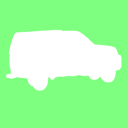

In [4]:
raw_image_test = Image.open("car.png").convert("RGB").resize((512, 512))

# These are the coordinates of two points on the car
input_points_test = [[[150, 170], [300, 250]]]

mask_test = get_processed_inputs(raw_image_test, input_points_test)

Image.fromarray(mask_to_rgb(mask_test)).resize((128, 128))

## Inpainting

After the segmentation part is being secured, the image manipulation needs to be prepared

In [ ]:
pipeline = AutoPipelineForInpainting.from_pretrained(
   "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16
).to(device)
pipeline.enable_model_cpu_offload()

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
def inpaint(raw_image, input_mask, prompt, negative_prompt=None, seed=74294536, cfgs=7):
    
    mask_image = Image.fromarray(input_mask)
    
    rand_gen = torch.manual_seed(seed)
    
    image = pipeline(
        image=raw_image,
        mask_image=mask_image,
        prompt=prompt,
        negative_prompt=negative_prompt if (negative_prompt is not None) else [],
        rand_gen=rand_gen,
        cfgs=cfgs
    ).images[0]
    
    return image

Completing the experiment with a prompt that describes what should be changed within the original image

In [ ]:
prompt_test = "a car driving on Mars. Studio lights, 1970s"
negative_prompt_test = "artifacts, low quality, distortion"

image = inpaint(raw_image_test, mask_test, prompt_test, negative_prompt_test)

In [ ]:
fig = make_image_grid([raw_image_test, Image.fromarray(mask_to_rgb(mask_test)), image.resize((512, 512))], rows=1, cols=3)
fig